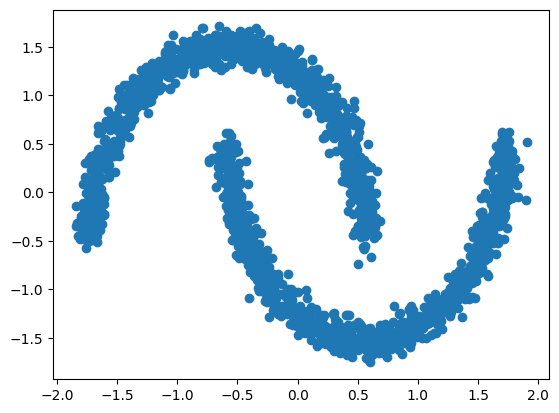

In [11]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import jax
import flax
from typing import Sequence
n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)   
X = jnp.array(X)
#PLOT X
plt.scatter(X[:, 0], X[:, 1])
# Initialize parameters, not committing to a batch shape
rng = random.PRNGKey(0)
D = 2
#parameter initialization


In [2]:
import random

def sample_n01(N):
    D = 2
    return jax.random.normal(rng,(N,D))    

def log_prob_n01(x):
    return -jnp.sum(-jnp.square(x)/2 - jnp.log(jnp.sqrt(2*jnp.pi))  , axis = -1)

In [3]:
def nvp_forward(net_params, shift_and_log_scale_fn, x, flip=False):
  d = x.shape[-1]//2
  x1, x2 = x[:, :d], x[:, d:]
  if flip:
    x2, x1 = x1, x2
  shift, log_scale = shift_and_log_scale_fn(net_params, x1)
  y2 = x2*jnp.exp(log_scale) + shift
  if flip:
    x1, y2 = y2, x1
  y = jnp.concatenate([x1, y2], axis=-1)
  return y

In [4]:
def nvp_inverse(net_params, shift_and_log_scale, y, flip = False): 
    d = y.shape[-1] // 2
    y1, y2 = y[:, :d], y[:, d:]
    print("y1 and y2 shape", y1.shape,y2.shape)
    if flip:
        y1, y2 = y2, y1 
    #log_scale = 
    shift, log_scale = shift_and_log_scale(net_params, y1)
    x2 = (y2 - shift) * jnp.exp(-log_scale)
    if flip:
        y1, x2 = x2, y1
    x = jnp.concatenate([y1, x2], axis=-1)
    return x, log_scale

In [5]:
def sample_nvp(net_params, shift_log_scale_fn, base_sample_fn, N, flip=False):
    x = base_sample_fn(N)
    return nvp_forward(net_params, shift_log_scale_fn, x, flip=flip)

def log_prob_nvp(net_params, shift_log_scale_fn, base_log_prob_fn, y, flip=False):
    x, log_scale = nvp_inverse(net_params, shift_log_scale_fn, y, flip=flip)
    print(x)
    ildj = -jnp.sum(log_scale, axis=-1)
    return base_log_prob_fn(x) + ildj

In [6]:
#need stax imports for this part in particular...

from jax.example_libraries import stax # neural network library
from jax.example_libraries.stax import Dense, Relu 

def init_nvp():
    D = 2
    net_init, net_apply = stax.serial(
    Dense(512), Relu, Dense(512), Relu, Dense(D))
    in_shape = (-1, D//2)
    out_shape, net_params = net_init(rng, in_shape)
    #passed onto 
    def shift_and_log_scale_fn(net_params, x1):
        s = net_apply(net_params, x1)
        print("s applied", s.shape)
        return jnp.split(s, 2, axis=1)
    return net_params, shift_and_log_scale_fn

def init_nvp_chain(n=2):
    flip = False
    ps, configs = [], []
    for i in range(n):
        p, f = init_nvp()
        ps.append(p), configs.append((f, flip))
        flip = not flip
    return ps, configs

In [7]:
ps, configs = init_nvp_chain()
#sanity check on y1 and y2 shapes in nvp_inverse
for p, c in zip(ps, configs):
    log_prob_fn = log_prob_n01
    fn , flip = c
    nvp_inverse(p, fn, X, flip)

y1 and y2 shape (2000, 1) (2000, 1)
s applied (2000, 2)
y1 and y2 shape (2000, 1) (2000, 1)
s applied (2000, 2)


In [9]:
def init_nvp_chain(n=2):
  flip = False
  ps, configs = [], []
  for i in range(n):
    p, f = init_nvp()
    ps.append(p), configs.append((f, flip))
    flip = not flip
  return ps, configs

def sample_nvp_chain(ps, configs, base_sample_fn, N):
  x = base_sample_fn(N)
  for p, config in zip(ps, configs):
    shift_log_scale_fn, flip = config
    x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
  return x

def make_log_prob_fn(p, log_prob_fn, config):
  shift_log_scale_fn, flip = config
  return lambda x: log_prob_nvp(p, shift_log_scale_fn, log_prob_fn, x, flip=flip)

def log_prob_nvp_chain(ps, configs, base_log_prob_fn, y):
  log_prob_fn = base_log_prob_fn
  for p, config in zip(ps, configs):
    log_prob_fn = make_log_prob_fn(p, log_prob_fn, config)
  return log_prob_fn(y)

In [12]:
net_init, net_apply = stax.serial(
    Dense(512), Relu, Dense(512), Relu, Dense(D))
in_shape = (-1, D//2)
out_shape, net_params = net_init(rng, in_shape)
print('initialized parameter shapes:\n', jax.tree_util.tree_map(jnp.shape, flax.core.unfreeze(net_params)))

initialized parameter shapes:
 [((1, 512), (512,)), (), ((512, 512), (512,)), (), ((512, 2), (2,))]


Flax Portion

In [15]:

import flax.linen as nn

In [16]:
#implement nvp chain init for an individual chain 
#only returns shift_and_log_scale_fn, as params are instead retrieved during initialization (in a dictionary format that is incompatible with original nvp_chain functions)
class NVP_init(nn.Module):
    D : int
    def setup(self):
        #allow initial input of just 1d vector
        self.layers = [nn.Dense(512), nn.relu, nn.Dense(512), nn.relu, nn.Dense(D)]
    def __call__(self, x1):
        s = x1 #renamed to s to avoid confusion with original code names, but otherwise unnecessary
        for i, layer in enumerate(self.layers):
            s = layer(s)
        return s
    
"""
#initialization of weights and params:
#create another random key for this
D = 2
seed = random.PRNGKey(0)
in_shape = (-1, D//2)
res = NVP_init(D)
params = res.init(seed, X)
y = res.apply(params, X)

print('initialized parameter shapes:\n', jax.tree_util.tree_map(jnp.shape, flax.core.unfreeze(params)))
initialized parameter shapes:
 {'params': {'layers_0': {'bias': (512,), 'kernel': (2, 512)}, 'layers_2': {'bias': (512,), 'kernel': (512, 512)}, 'layers_4': {'bias': (2,), 'kernel': (512, 2)}}}
 
 out shape of y: (2000, 2) Is that right???
"""


"\n#initialization of weights and params:\n#create another random key for this\nD = 2\nseed = random.PRNGKey(0)\nin_shape = (-1, D//2)\nres = NVP_init(D)\nparams = res.init(seed, X)\ny = res.apply(params, X)\n\nprint('initialized parameter shapes:\n', jax.tree_util.tree_map(jnp.shape, flax.core.unfreeze(params)))\ninitialized parameter shapes:\n {'params': {'layers_0': {'bias': (512,), 'kernel': (2, 512)}, 'layers_2': {'bias': (512,), 'kernel': (512, 512)}, 'layers_4': {'bias': (2,), 'kernel': (512, 2)}}}\n \n out shape of y: (2000, 2) Is that right???\n"

In [ ]:
# D = 2
# in_shape = (-1, D//2)
# res = NVP_init(D)
# params = res.init(rng, (-1,1))
# #take just the first axis of X
# X_in = X[:, :D//2]
# y = res.apply(params, X)

# print('initialized parameter shapes:\n', jax.tree_util.tree_map(jnp.shape, flax.core.unfreeze(params)))

initialized parameter shapes:
 {'params': {'layers_0': {'bias': (512,), 'kernel': (2, 512)}, 'layers_2': {'bias': (512,), 'kernel': (512, 512)}, 'layers_4': {'bias': (2,), 'kernel': (512, 2)}}}


In [17]:
def flax_build_nvp_chain(n=2, D = 2):
    flip = False
    params, configs = [], []
    flow_layers = [NVP_init(D)
                for i in range(n) ]
    return flow_layers

print(flax_build_nvp_chain(4, 2))


[NVP_init(
    # attributes
    D = 2
), NVP_init(
    # attributes
    D = 2
), NVP_init(
    # attributes
    D = 2
), NVP_init(
    # attributes
    D = 2
)]


In [20]:
class OverallFlow(nn.Module):
    flows : Sequence[nn.Module]
    flips : Sequence[bool]
    base_log_prob_fn : callable
    def __call__(self, X):
       # in_shape = (-1, 1)
        log_prob_fn = self.base_log_prob_fn
        #have this iterate over the flows and the flips simultenously, and apply the right transformations at the right times
        for flow, flip in zip(self.flows, self.flips):
            #initialize flow layer
            #try this adjustd input shape since (-1,1) expects kernel0 (2, 512) but going to have 1D inputs...
            params = flow.init(rng,X[:, :D//2])

            #will probably go wrong...
            def shift_and_log_scale_fn(net_params, x1):
                s = flow.apply(params, x1)
                return jnp.split(s, 2, axis=1)
            #using the log_scale_fn and the flip setting, call 
            log_prob_fn = self.make_log_prob_fn(params, log_prob_fn, shift_and_log_scale_fn, flip)
        #return final log prob transform
        return log_prob_fn(X)
    
    def make_log_prob_fn(self, params, base_log_prob_fn, shift_and_log_scale_fn, flip):
        #TODO
        return lambda x: log_prob_nvp(params, shift_and_log_scale_fn, base_log_prob_fn, x, flip=flip)
    
    def log_prob_nvp(self,params, shift_and_log_scale_fn, base_log_prob_fn, X, flip=False):
        #print("reached")
        x, log_scale = nvp_inverse(params, shift_and_log_scale_fn, X, flip)
        print("x, log_scale", x.shape, log_scale.shape)

D =2
model = OverallFlow(flax_build_nvp_chain(4, 2), [False, True, False, True], log_prob_n01)
params = model.init(rng, X[:, :D//2])

print("result \n",model.apply(params, X))
print('initialized parameter shapes:\n', jax.tree_util.tree_map(jnp.shape, flax.core.unfreeze(params)))


y1 and y2 shape (2000, 0) (2000, 1)
[[ 1.733752  ]
 [-0.3701875 ]
 [ 0.5243546 ]
 ...
 [ 1.6954128 ]
 [-0.57149583]
 [-1.6116786 ]]
y1 and y2 shape (2000, 0) (2000, 1)


ZeroDivisionError: division by zero

In [19]:
class OverallFlow(nn.Module):
    flows : Sequence[nn.Module]
    flips : Sequence[bool]
    base_log_prob_fn : callable
    def __call__(self, X):
       # in_shape = (-1, 1)
        log_prob_fn = self.base_log_prob_fn
        #have this iterate over the flows and the flips simultenously, and apply the right transformations at the right times
        for flow, flip in zip(self.flows, self.flips):
            #initialize flow layer
            #try this adjustd input shape since (-1,1) expects kernel0 (2, 512) but going to have 1D inputs...
            params = flow.init(rng,(-1,1))
    def make_log_prob_fn(self, params, base_log_prob_fn, shift_and_log_scale_fn, flip):
        #TODO
        return lambda x: log_prob_nvp(params, shift_and_log_scale_fn, base_log_prob_fn, x, flip=flip)
    
    #initialize all the individual flows
    def encode_nvp_shit_and_log_scale(self, rng, X):
        for flow, flip in zip(self.flows, self.flips):
            params = flow.init(rng, (-1,1))
            s = flow.apply(params, X)
            
    def log_prob_nvp(self,params, shift_and_log_scale_fn, base_log_prob_fn, X, flip=False):
        #print("reached")
        x, log_scale = nvp_inverse(params, shift_and_log_scale_fn, X, flip)
        print("x, log_scale", x.shape, log_scale.shape)

D =2
model = OverallFlow(flax_build_nvp_chain(4, 2), [False, True, False, True], log_prob_n01)
params = model.init(rng, (-1,1))

print("result \n",model.apply(params, X))
print('initialized parameter shapes:\n', jax.tree_util.tree_map(jnp.shape, flax.core.unfreeze(params)))

result 
 None
initialized parameter shapes:
 {}


In [ ]:
res

(Array([[ 0.70877934, -1.0664397 ],
        [-0.6057626 ,  1.0316335 ],
        [-1.5421597 ,  0.12892427],
        ...,
        [-0.13845241, -1.3266487 ],
        [ 0.50201964, -1.2728287 ],
        [ 0.6450542 , -1.1926771 ]], dtype=float32),
 Array([[0.39245453],
        [0.32465732],
        [0.04057277],
        ...,
        [0.4882126 ],
        [0.4684067 ],
        [0.43891037]], dtype=float32))

In [ ]:
def nvp_inverse(net_params, shift_and_log_scale_fn, y, flip=False):
  d = y.shape[-1]//2
  y1, y2 = y[:, :d], y[:, d:]
  if flip:
    y1, y2 = y2, y1
  #print("y1 and y2 shape", y1.shape,y2.shape) (2000, 1) (2000, 1) looks about right? 
  shift, log_scale = shift_and_log_scale_fn(net_params, y1)
  x2 = (y2-shift)*jnp.exp(-log_scale)
  if flip:
    y1, x2 = x2, y1
  x = jnp.concatenate([y1, x2], axis=-1)
  return x, log_scale

In [ ]:
x, log_scale = nvp_inverse(ps, fn, X, flip )

#y1 and y2 shape also (2000, 1) each

In [ ]:
#change of variable (inverse transform sampling)
class LogProbInverse(nn.Module):
    @nn.compact
    def __call__(self, net_params, shift_log_scale_fn, base_log_prob_fn, y, flip=False):
        x, log_scale = nvp_inverse(net_params, shift_log_scale_fn, y, flip=flip)
        ildj = -jnp.sum(log_scale, axis=-1)
        return base_log_prob_fn(x) + ildj
    
# forward implementation (affine coupling)
class SampleNVPForward(nn.Module):
    @nn.compact
    def __call__(self, net_params, shift_log_scale_fn, base_sample_fn, N, flip=False):
        x = base_sample_fn(N)
        return nvp_forward(net_params, shift_log_scale_fn, x, flip=flip)

In [ ]:
def init_nvp_chain(n =4):
    flip = False
    ps, configs = [], []
    for i in range(n):
        
        p, f = init_nvp()